In [1]:
import sys, os
script_directory = os.path.abspath('.')
print(script_directory)
sys.path.append(script_directory)

e:\Programming\Python\project_GeoNeuro\project_moires\spatial_cognition_moire\Analysis


In [2]:
# ref 这波是改工作目录，默认为ipynb文件所在目录
os.chdir(os.path.abspath('..'))
print(os.getcwd())

e:\Programming\Python\project_GeoNeuro\project_moires\spatial_cognition_moire


In [3]:
sys.path

['d:\\Application\\Conda\\envs\\geoneuro\\python39.zip',
 'd:\\Application\\Conda\\envs\\geoneuro\\DLLs',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro',
 '',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\Pythonwin',
 'e:\\Programming\\Python\\project_GeoNeuro\\project_moires\\spatial_cognition_moire\\Analysis']

In [4]:
import shap
# ref 和Python文件不一样，jupyter会自动检索工作目录的模块，如果存在则自动添加到sys.path中，不需要手动添加
import packFuncForShap as pack4shap
sys.path

['d:\\Application\\Conda\\envs\\geoneuro\\python39.zip',
 'd:\\Application\\Conda\\envs\\geoneuro\\DLLs',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro',
 '',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\win32\\lib',
 'd:\\Application\\Conda\\envs\\geoneuro\\lib\\site-packages\\Pythonwin',
 'e:\\Programming\\Python\\project_GeoNeuro\\project_moires\\spatial_cognition_moire\\Analysis',
 'e:\\Programming\\Python\\project_GeoNeuro\\project_moires\\spatial_cognition_moire']

In [5]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
from itertools import repeat, chain
from functools import partial

In [6]:
import importlib
importlib.reload(pack4shap)
import pickle

In [7]:
save_path = 'E:/Research/202305 GeoNeuro/Pre/Figures/'

In [7]:
evolution_model_path = r'./model/36384703(default)/complete_model'
params_list = os.listdir(evolution_model_path)
date_list = [int(params.rstrip('.pickle')) for params in params_list]
date_list = date_list[::7]

In [9]:
shap_calculates = dict()

for date in date_list:
    print('Iteration date: {date}'.format(date=date))
    path = evolution_model_path + '/{date}.pickle'.format(date=date)

    model = pack4shap.loadModel(path=path)
    modelPredWrapper = partial(pack4shap.modelPredict, model=model, attribute_type='reward')

    dataset = pack4shap.backgroundData(date = date)
    dataset_uni = np.unique(dataset, axis=0)
    print('Data with {k} rows'.format(k=dataset_uni.shape[0]))

    built_bench = np.zeros(model.s_dim).reshape(1, -1)
    locat_bench = np.mean(dataset[:, model.s_dim:], axis=0).reshape(1, -1)
    zero_bench = np.zeros(dataset.shape[1]).reshape(1, -1)
    home_bench = np.hstack((built_bench, locat_bench))

    explainer = shap.PermutationExplainer(modelPredWrapper, home_bench)
    shap_values = explainer(dataset_uni)
    print()
    shap_calculates[date] = shap_values
    with open('./product/shap_results.pickle', 'wb') as f:
        pickle.dump(shap_calculates, f)

Iteration date: 20190707


FileNotFoundError: [Errno 2] No such file or directory: './data/user_data/36384703/before_migrt.json'

In [6]:
with open('./product/shap_results.pickle', 'rb') as f:
    shap_calculates = pickle.load(f)

In [28]:
shap_values = shap_calculates[20190707]

In [8]:
varchr = 'home_distance,LU_Business,LU_City_Road,LU_Consumption,LU_Culture,LU_Industry,LU_Medical,LU_Park_&_Scenery,LU_Public,LU_Residence,LU_Science_&_Education,LU_Special,LU_Transportation,LU_Wild'
varname_BE = varchr.split(',')
varname_PE = ['PE%02d' % i for i in range(6 * len(varname_BE))]
varname = varname_BE + varname_PE
groupmap = {
    'BuiltAttr': varname[:14],
    'Location': varname[14:]
}

In [9]:
def grouped_shap(shap_vals, features, groups):
    revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))    
    
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

shap_groups = [grouped_shap(shap_vals=shap_values.values, features=varname, groups=groupmap) for shap_values in shap_calculates.values()]


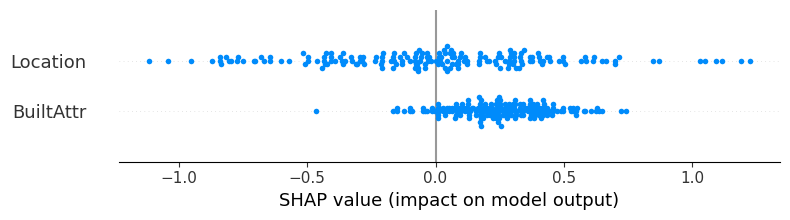

In [21]:
shap.summary_plot(shap_groups[0].values, features=shap_groups[0].columns)

In [41]:
[np.abs(shap_group.to_numpy()).mean(axis=0) for shap_group in shap_groups]

[array([0.26544334, 0.34821922]),
 array([0.22709377, 0.31956049]),
 array([0.20212909, 0.27512485]),
 array([0.18119031, 0.25772984]),
 array([0.18313264, 0.25171924]),
 array([0.13666154, 0.22788395]),
 array([0.10710524, 0.2090997 ]),
 array([0.09467388, 0.19354023]),
 array([0.08337173, 0.1752699 ]),
 array([0.07774873, 0.17746285]),
 array([0.07190034, 0.16776664]),
 array([0.06773915, 0.16148704]),
 array([0.06871705, 0.16575081]),
 array([0.06620341, 0.15976782]),
 array([0.06184063, 0.14295139]),
 array([0.05383955, 0.1348622 ]),
 array([0.0516635 , 0.12936071]),
 array([0.04993415, 0.12209753]),
 array([0.04780919, 0.11624306]),
 array([0.04646633, 0.1145877 ]),
 array([0.04656302, 0.10994515]),
 array([0.04943983, 0.11023461]),
 array([0.04761842, 0.10437344]),
 array([0.04844023, 0.10532066]),
 array([0.04700578, 0.10357835])]

In [13]:
ans = [np.abs(shap_group.to_numpy()).mean(axis=0) for shap_group in shap_groups]
shap_val = np.array(ans)

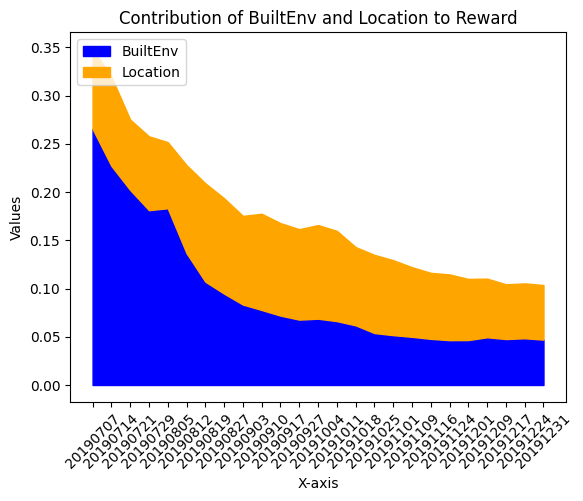

In [28]:


x = np.arange(len(shap_val))
# 创建图形和轴
fig, ax = plt.subplots()

y1 = shap_val[:, 0]
y2 = shap_val[:, 1]
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward')
ax.set_xlabel('X-axis')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in date_list], rotation=45)

# 显示图表
plt.show()

In [30]:
shap_ratio = shap_val / shap_val.sum(axis=1).reshape(-1, 1)

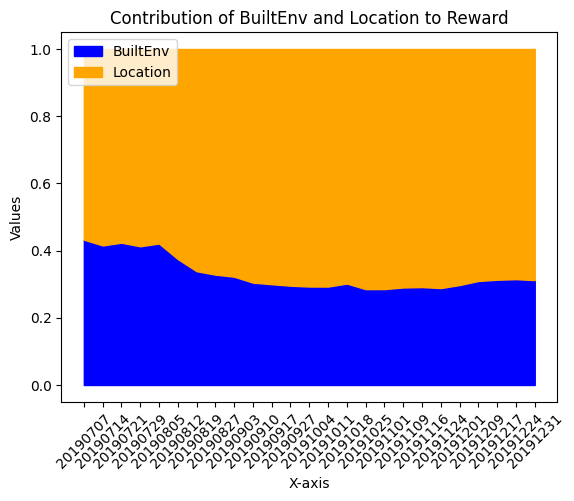

In [31]:
x = np.arange(len(shap_val))
# 创建图形和轴
fig, ax = plt.subplots()

y1 = shap_ratio[:, 0]
y2 = np.ones_like(y1)
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward')
ax.set_xlabel('X-axis')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in date_list], rotation=45)

# 显示图表
plt.show()

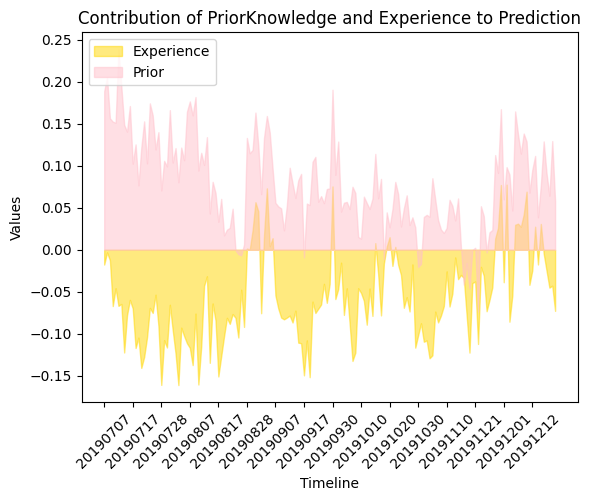

In [42]:
import pandas as pd

df_eval = pd.read_csv('./product/evolution_evaluation.csv')

x = df_eval.index
# 创建图形和轴
fig, ax = plt.subplots()

y1 = df_eval.pr_mse_contrib
y2 = df_eval.exp_mse_contrib

y1 = df_eval.pr_mse_contrib
y2 = df_eval.exp_mse_contrib

# 绘制堆叠区域
ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Experience')  # 绿色区域，堆叠在蓝色区域之上
ax.fill_between(x, y1, color='pink', alpha=0.5, label='Prior')  # 蓝色区域

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of PriorKnowledge and Experience to Prediction')
ax.set_xlabel('Timeline')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x[::10])
labels = [str(d) for d in df_eval.date]
ax.set_xticklabels(labels[::10], rotation=45)

# 显示图表
plt.show()

Analysis

In [16]:
shap_path = './product/shap_personne/'
shap_list = os.listdir(shap_path)

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: './product/shap_personne/'

In [8]:
with open(shap_path + shap_list[-1], 'rb') as f:
    shap_calculates = pickle.load(f)


In [9]:
shap_res = shap_calculates.copy()

In [10]:
shap_list

['shap_res_21410711.pkl',
 'shap_res_33816672.pkl',
 'shap_res_37852495.pkl',
 'shap_res_43283109.pkl',
 'shap_res_63445952.pkl',
 'shap_res_68492654.pkl',
 'shap_res_four_indivis.pkl']

In [11]:
for file in shap_list[:-1]:
    with open(shap_path + file, 'rb') as f:
        shap_one_person = pickle.load(f)
    who = int(file.rstrip('.pkl').split('_')[-1])
    for date in shap_one_person.keys():
        shap_res[(who, date)] = shap_one_person[date]

In [12]:
keyData = list(shap_res.keys())
keyDf = pd.DataFrame(keyData, columns=['who', 'date'])
whos = keyDf.who.unique()

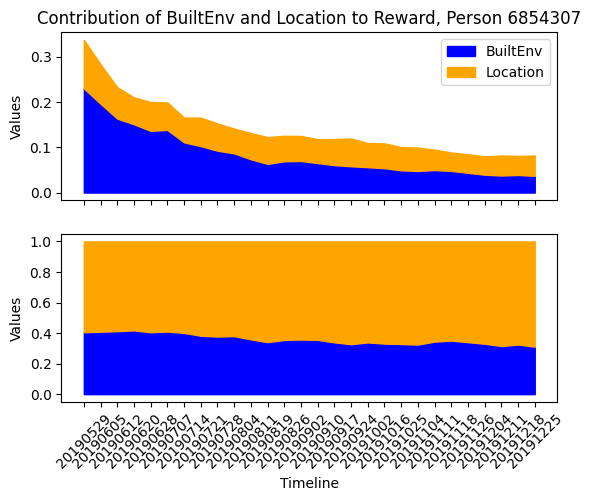

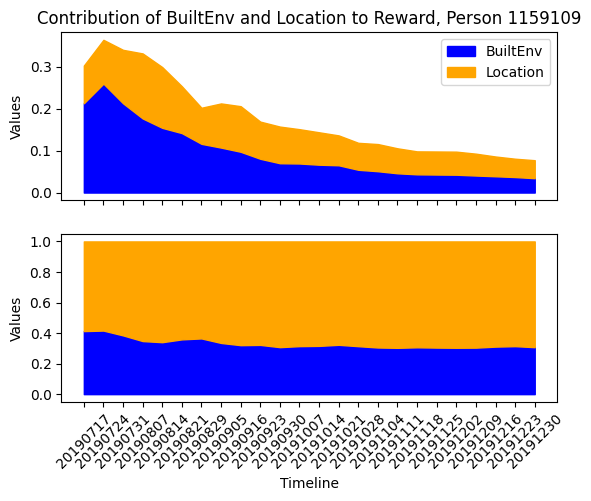

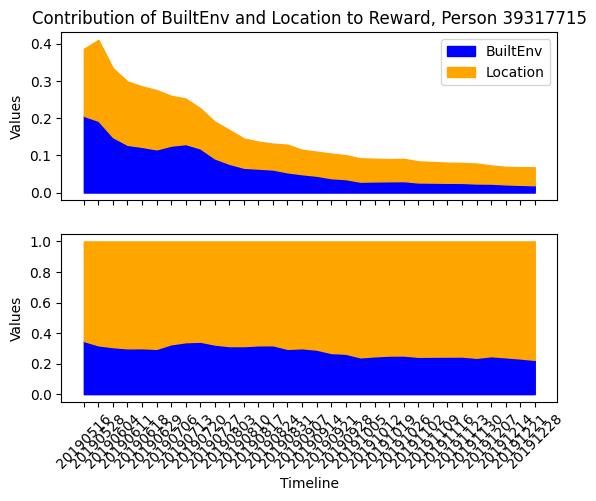

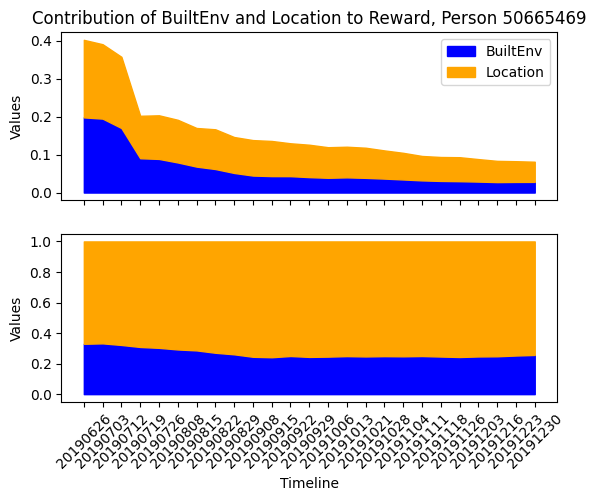

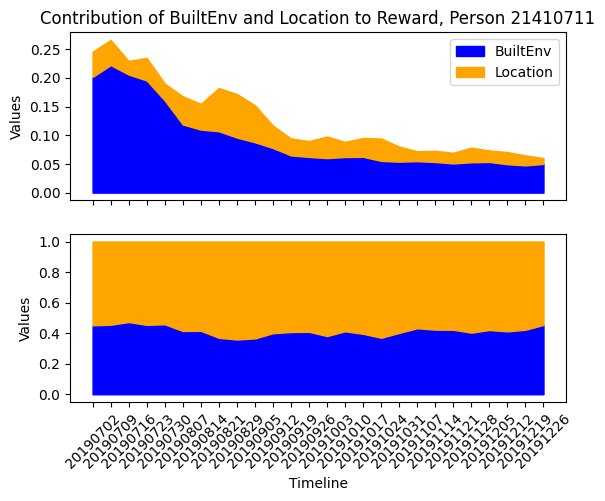

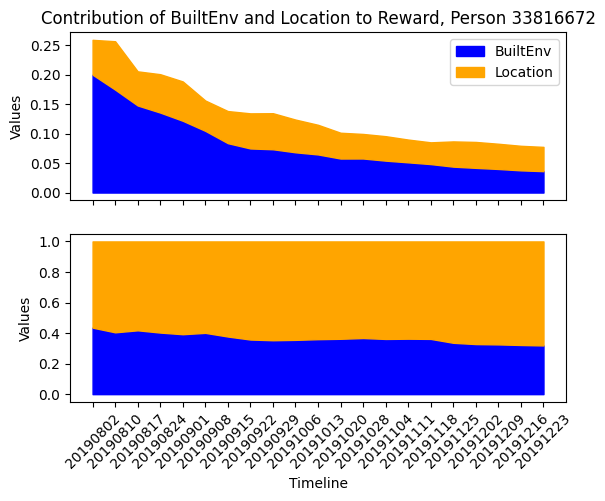

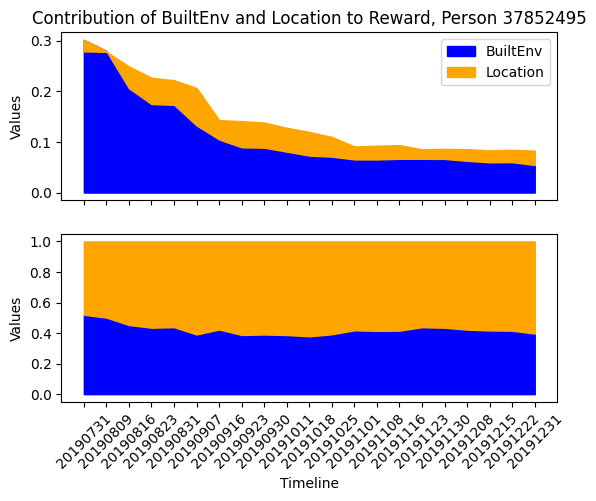

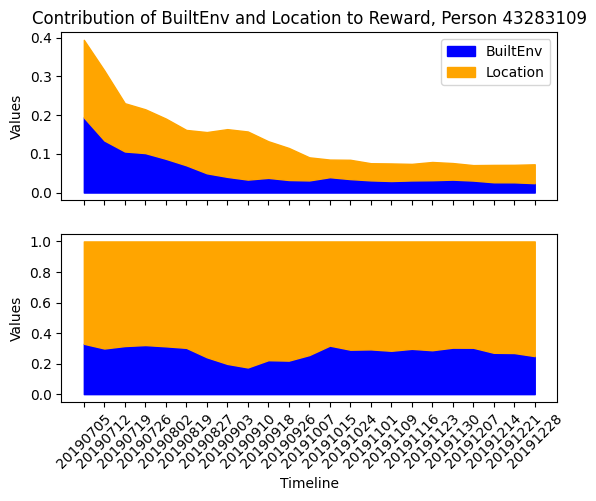

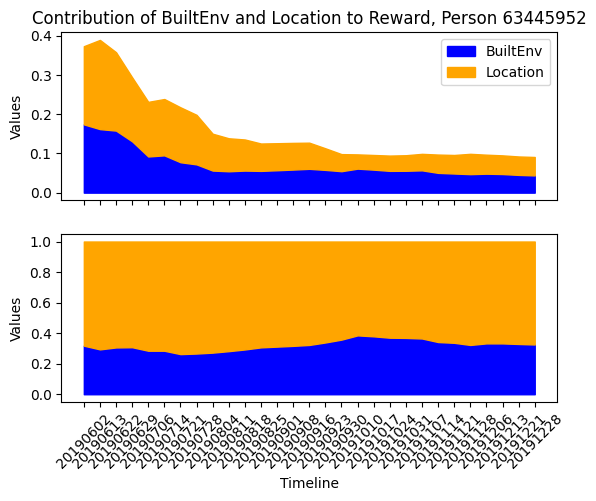

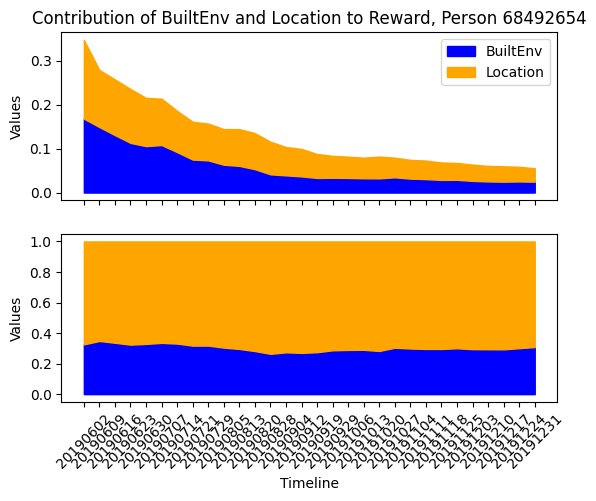

In [21]:
from matplotlib import pyplot as plt

for who in whos:
    keyWho = [(pair[0], pair[1]) for pair in keyData if pair[0] == who]
    keyWho.sort(key=lambda x: x[1])
    shap_agg = [shap_res[pair].abs().mean(axis=0) for pair in keyWho]
    
    shap_val = pd.concat(shap_agg, axis=1).T.to_numpy()
    shap_ratio = shap_val / shap_val.sum(axis=1).reshape(-1, 1)
    date_list = [pair[1] for pair in keyWho]
    
    # drawing...
    x = np.arange(len(shap_val))
    # 创建图形和轴
    fig, ax = plt.subplots(2, 1)

    y1 = shap_val[:, 0]
    y2 = shap_val[:, 1]
    # 绘制堆叠区域
    ax[0].fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
    ax[0].fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

    # 设置图例
    ax[0].legend(loc='upper right')

    # 设置图表标题和坐标轴标签
    ax[0].set_title(f'Contribution of BuiltEnv and Location to Reward, Person {who}')
    ax[0].set_xlabel(None)
    ax[0].set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax[0].set_xticks(x)
    ax[0].set_xticklabels([])

    y1 = shap_ratio[:, 0]
    y2 = np.ones_like(y1)
    # 绘制堆叠区域
    ax[1].fill_between(x, y1, color='b', label='BuiltEnv')  # 蓝色区域
    ax[1].fill_between(x, y1, y2, color='orange', label='Location')  # 绿色区域，堆叠在蓝色区域之上

    # 设置图例

    # 设置图表标题和坐标轴标签
    ax[1].set_title(None)
    ax[1].set_xlabel('Timeline')
    ax[1].set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax[1].set_xticks(x)
    ax[1].set_xticklabels([str(d) for d in date_list], rotation=45)

    plt.savefig('./product/person_{who:08d}_shap.png'.format(who=who))
    # 显示图表
    plt.show()

In [28]:
interp_path = './product/interpretEvo/'
interp_list = os.listdir(interp_path)

interp_res = dict()
for file in interp_list:
    with open(interp_path + file, 'rb') as f:
        interp_one_person = pickle.load(f)
    key = interp_one_person.keys()
    key = list(key)[0]
    interp_res[key] = interp_one_person[key]

In [32]:
interp_one_person[68492654]

,date,pr_contrib,exp_contrib
0,20190602,0.344455,0.019746
1,20190603,0.210646,0.133176
2,20190604,0.269047,0.066533
3,20190605,0.476513,0.029900
4,20190606,0.422389,0.059429
...,...,...,...
189,20191217,5.807609,0.026670
190,20191218,4.995370,0.093325
191,20191219,4.987492,0.085606
192,20191220,4.695856,0.087544


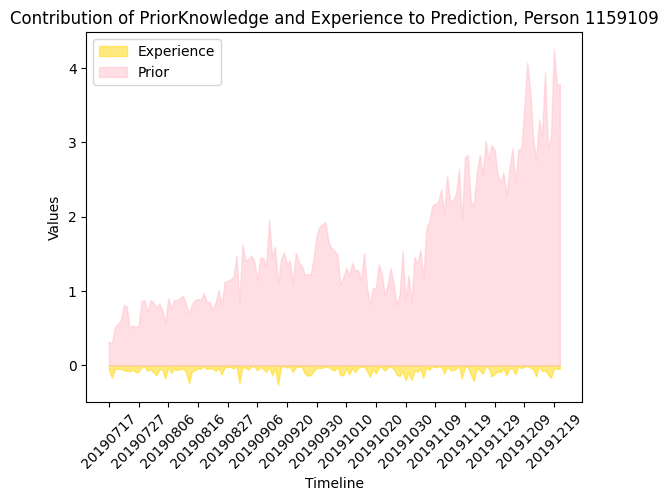

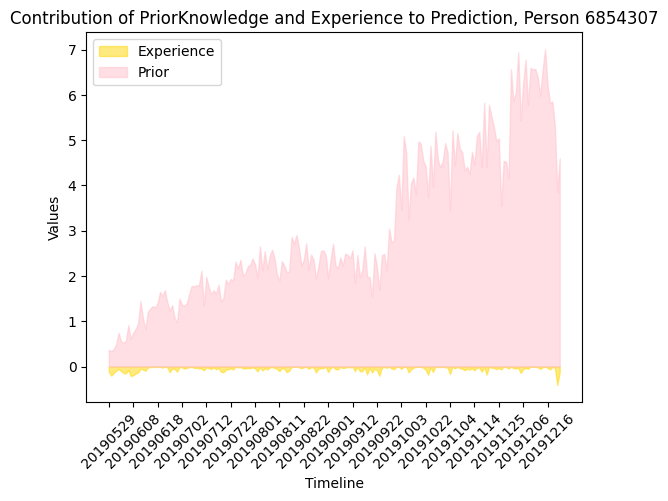

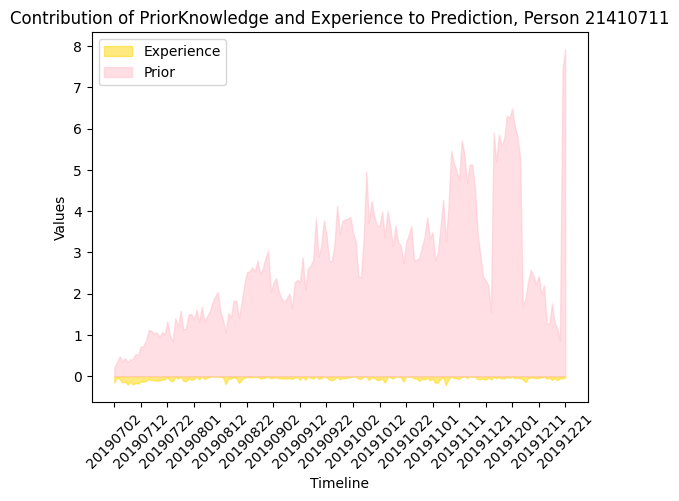

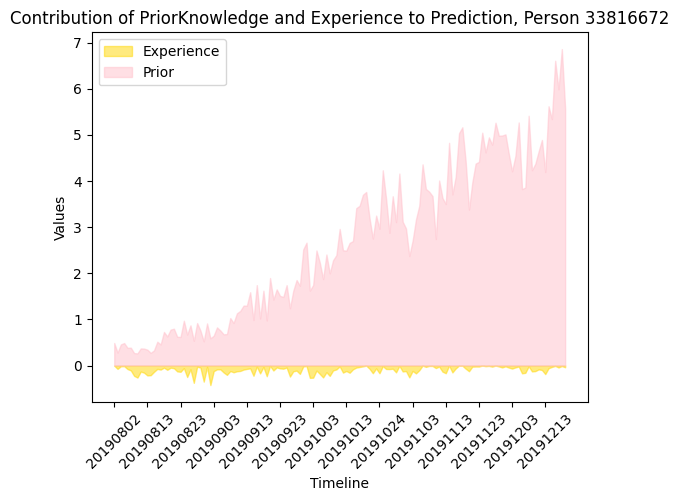

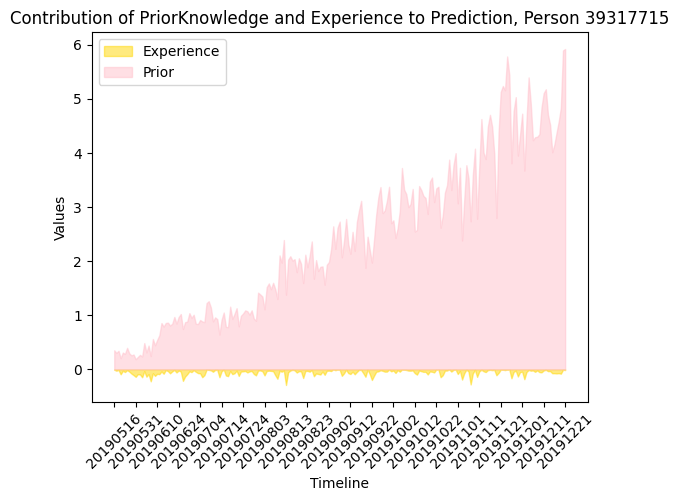

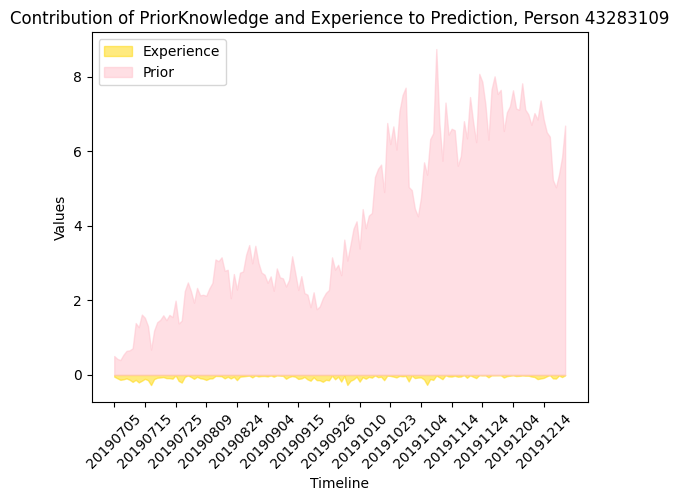

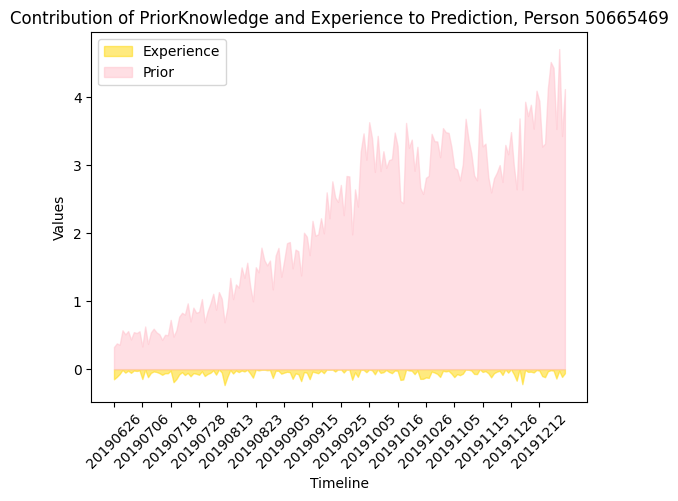

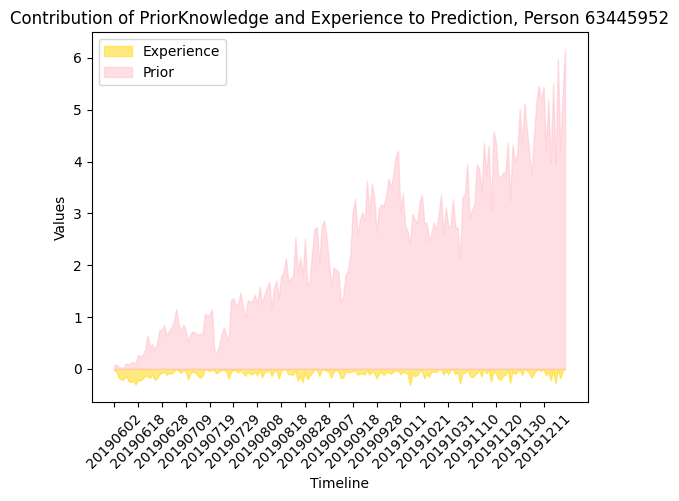

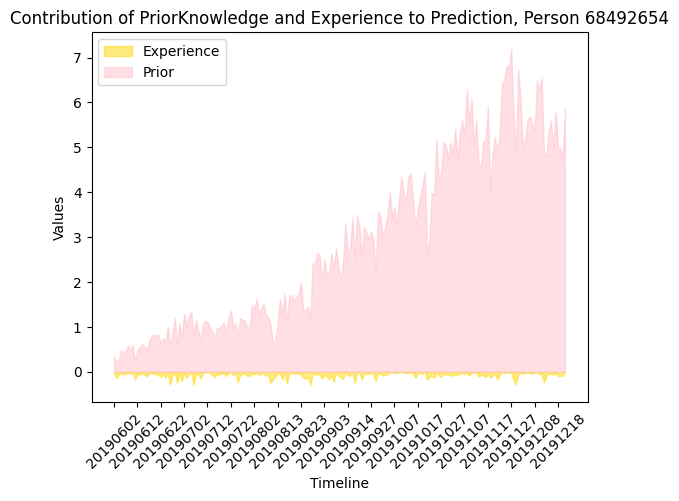

In [37]:
for who, interpDf in interp_res.items():
    x = interpDf.index
    # 创建图形和轴
    fig, ax = plt.subplots()

    y1 = interpDf.pr_contrib
    y2 = interpDf.exp_contrib

    # 绘制堆叠区域
    ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Experience')  # 绿色区域，堆叠在蓝色区域之上
    ax.fill_between(x, y1, color='pink', alpha=0.5, label='Prior')  # 蓝色区域

    # 设置图例
    ax.legend(loc='upper left')

    # 设置图表标题和坐标轴标签
    ax.set_title(f'Contribution of PriorKnowledge and Experience to Prediction, Person {who}')
    ax.set_xlabel('Timeline')
    ax.set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax.set_xticks(x[::10])
    labels = [str(d) for d in interpDf.date]
    ax.set_xticklabels(labels[::10], rotation=45)
    
    plt.savefig('./product/person_{who:08d}_interp.png'.format(who=who))
    # 显示图表
    plt.show()

In [11]:
reward_res_path = './product/reward_res.pkl'

with open(reward_res_path, 'rb') as f:
    reward_res = pickle.load(f)

Test on one user

In [8]:
shap_files_list = [file for file in os.listdir('./product/') if file.startswith('shap_res_')]
who_list = [int(file.lstrip('shap_res_').rstrip('.pkl')) for file in shap_files_list]

In [9]:
shap_res_lst = []
for file in shap_files_list:
    with open('./product/' + file, 'rb') as f:
        shap_res_lst.append(pickle.load(f))

In [10]:
shap_res_lst[0]

{20230610: (group  BuiltAttr  Location
  0      -0.016977 -0.259802
  1       0.000250 -0.142235
  2       0.018484  0.012583
  3       0.052704  0.003325
  4      -0.010109 -0.150628
  5      -0.139713  0.169741
  6       0.050243 -0.565225
  7      -0.130168 -0.091872
  8       0.062466  0.008589
  9       0.135422 -0.071796
  10      0.041386 -0.322375
  11     -0.060692 -0.201745
  12     -0.048138  0.036249
  13     -0.015494 -0.054591
  14     -0.090866 -0.064699
  15     -0.099027 -0.055453
  16     -0.091718 -0.053854
  17     -0.086785 -0.134733
  18      0.072803  0.053482
  19     -0.100309 -0.120942
  20      0.082414 -0.494288
  21      0.073732 -0.242587
  22     -0.059033 -0.560038
  23     -0.020405 -0.154520
  24     -0.049441  0.093586
  25      0.062298  0.128953
  26     -0.037376  0.111548
  27      0.056814 -0.094456
  28     -0.101934 -0.136713
  29     -0.029461 -0.070211
  30     -0.042560  0.024989
  31     -0.044796  0.022990
  32     -0.041220  0.018844
  33

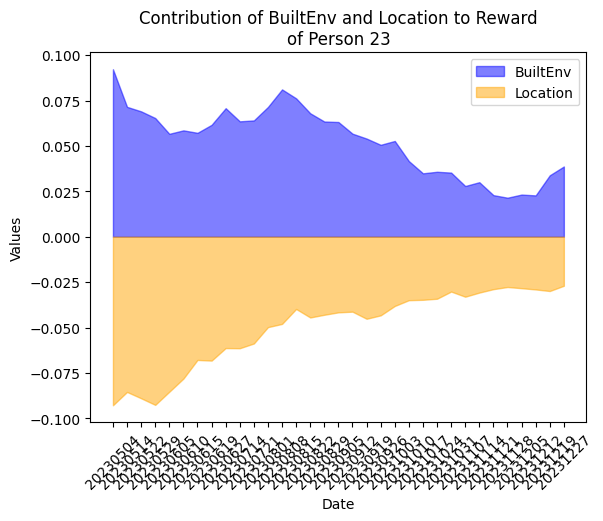

In [15]:
shap_res = shap_res_lst[0]
date_list = list(shap_res.keys())
date_list.sort()

be_contrib = [np.average(np.abs(shap_res[dt][0]['BuiltAttr'].to_numpy()), weights=shap_res[dt][1]) for dt in date_list]
pe_contrib = [np.average(np.abs(shap_res[dt][0]['Location'].to_numpy()), weights=shap_res[dt][1]) for dt in date_list]
x = np.arange(len(be_contrib))

# 创建图形和轴
fig, ax = plt.subplots()

y1 = np.array(be_contrib)
y2 = np.array(pe_contrib)
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', alpha=0.5, label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, -y2, color='orange', alpha=0.5, label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper right')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward\nof Person {who}'.format(who=23))
ax.set_xlabel('Date')
ax.set_ylabel('Values')

# ax_r = ax.twinx()  # 创建第二个坐标轴
# ax_r.plot(x, r_baseline, color='darkred', ls='-', marker='o', ms=4, label='Reward')
# ax_r.set_ylabel('Reward')
# ax_r.legend(loc='lower left')
# ax_r.set_ylim(0, None)

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in date_list], rotation=45)

# 显示图表
# plt.savefig(save_path + 'person_shap/XAI_{who:09d}.png'.format(who=who))
plt.show()

In [16]:
def drawShap(who):
    indices = who_list.index(who)
    shap_res = shap_res_lst[indices]
    date_list = list(shap_res.keys())
    date_list.sort()
    
    be_contrib = [np.average(np.abs(shap_res[dt][0]['BuiltAttr'].to_numpy()), weights=shap_res[dt][1]) for dt in date_list]
    pe_contrib = [np.average(np.abs(shap_res[dt][0]['Location'].to_numpy()), weights=shap_res[dt][1]) for dt in date_list]
    x = np.arange(len(be_contrib))
    
    # 创建图形和轴
    fig, ax = plt.subplots()

    y1 = np.array(be_contrib)
    y2 = np.array(pe_contrib)
    # 绘制堆叠区域
    ax.fill_between(x, y1, color='b', alpha=0.5, label='BuiltEnv')  # 蓝色区域
    ax.fill_between(x, -y2, color='orange', alpha=0.5, label='Location')  # 绿色区域，堆叠在蓝色区域之上

    # 设置图例
    ax.legend(loc='upper right')

    # 设置图表标题和坐标轴标签
    ax.set_title('Contribution of BuiltEnv and Location to Reward\nof Person {who}'.format(who=who))
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')

    # ax_r = ax.twinx()  # 创建第二个坐标轴
    # ax_r.plot(x, r_baseline, color='darkred', ls='-', marker='o', ms=4, label='Reward')
    # ax_r.set_ylabel('Reward')
    # ax_r.legend(loc='lower left')
    # ax_r.set_ylim(0, None)

    # 将横坐标的标签设置为日期datelist
    ax.set_xticks(x)
    ax.set_xticklabels([str(d) for d in date_list], rotation=45)

    # 显示图表
    # plt.savefig(save_path + 'person_shap/XAI_{who:09d}.png'.format(who=who))
    plt.show()

In [17]:
print(who_list)

[1102234, 4116450, 6945721, 10013454, 23951036, 25679537, 26564845, 44777185, 47319758, 54636959, 58124481, 58272403, 68058890, 71209087, 76012062, 82455786, 83227330, 89277020, 93854949, 102181433]


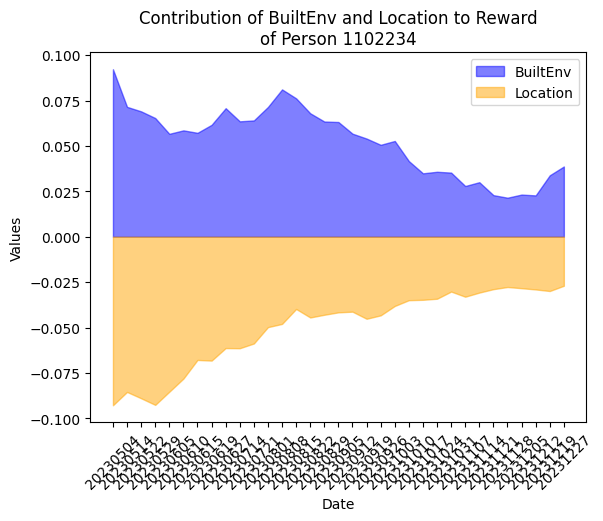

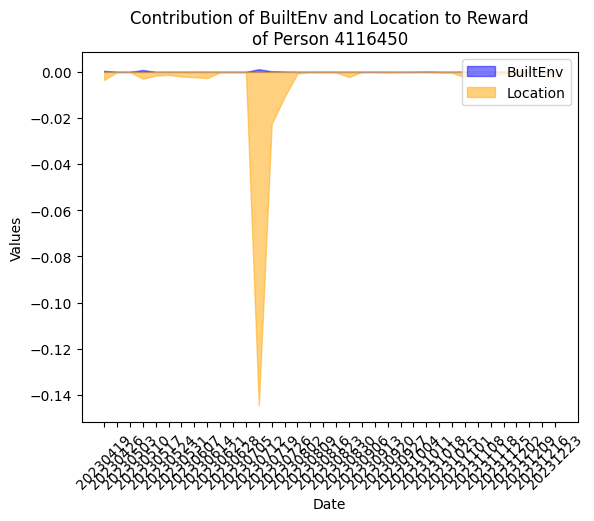

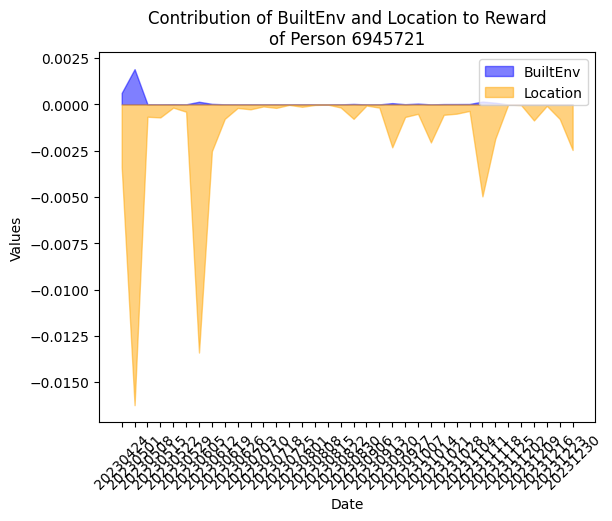

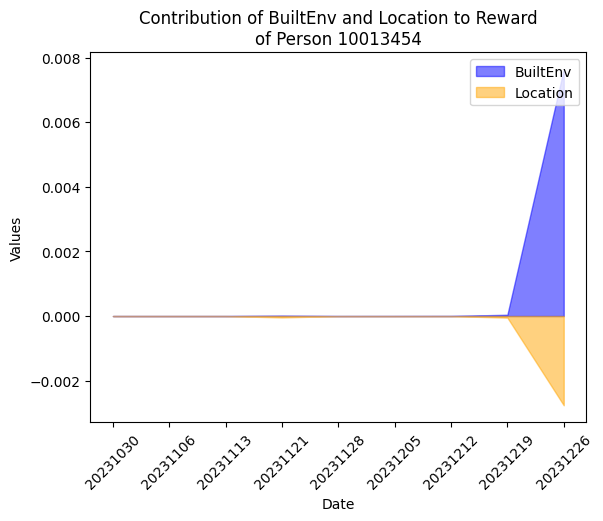

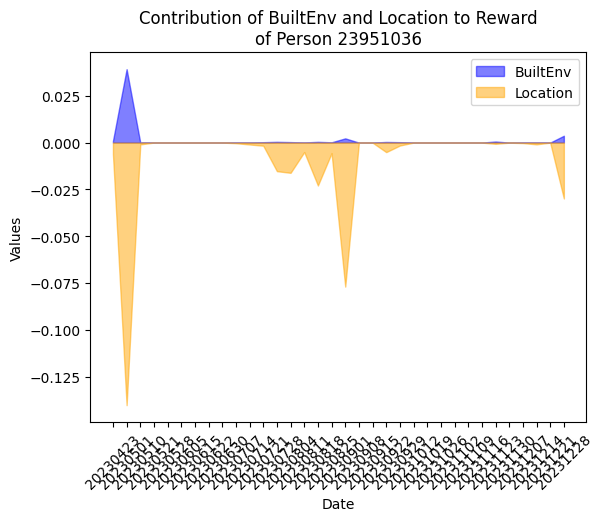

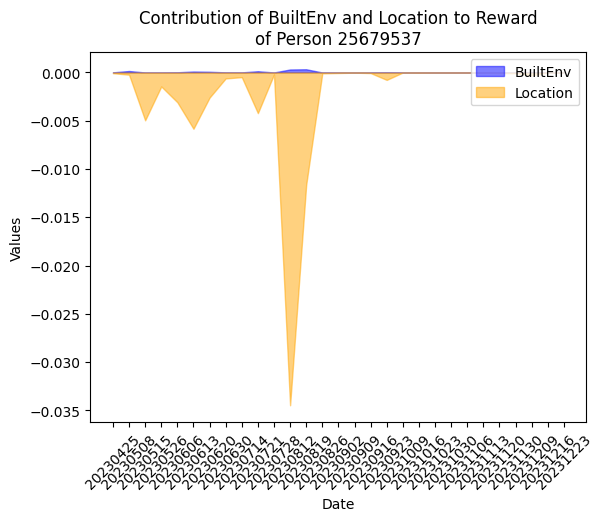

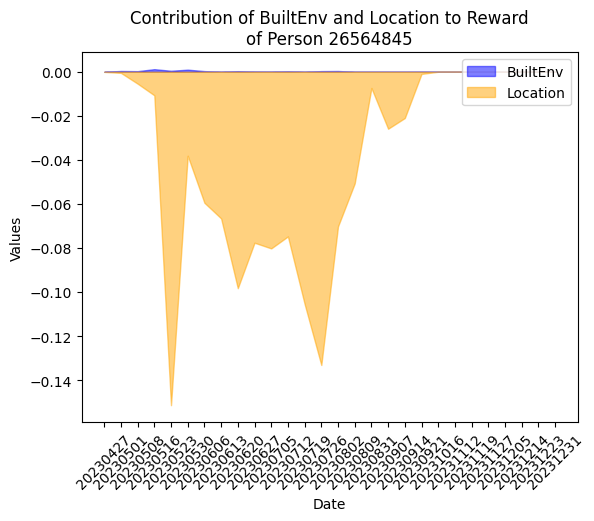

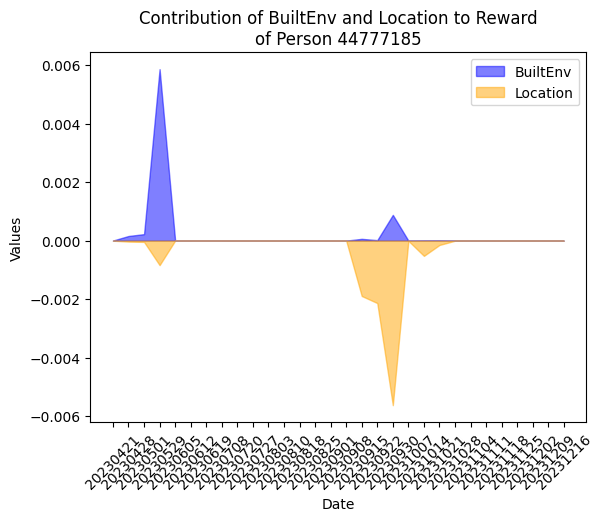

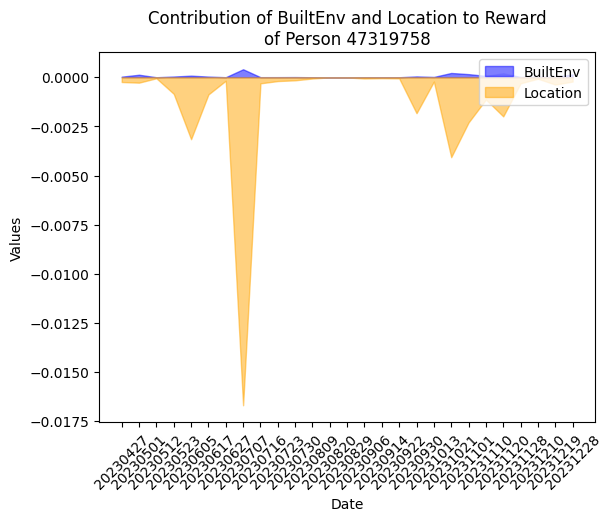

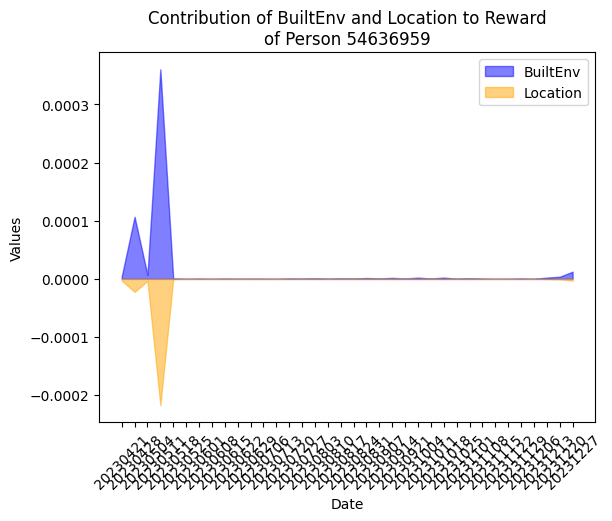

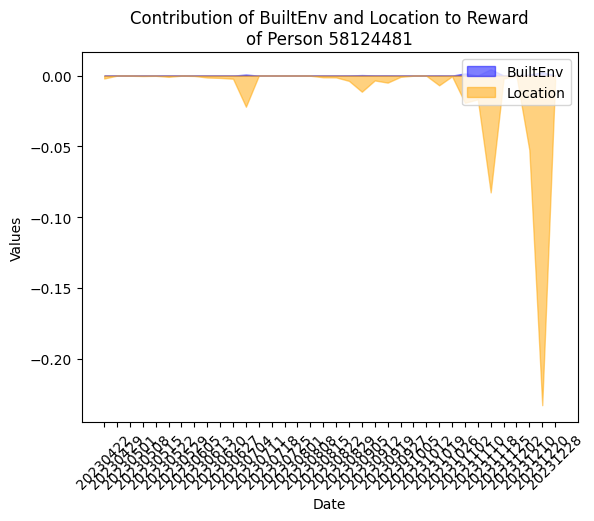

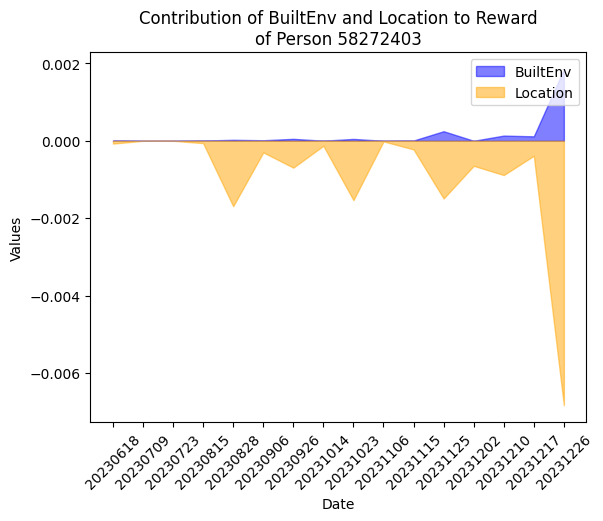

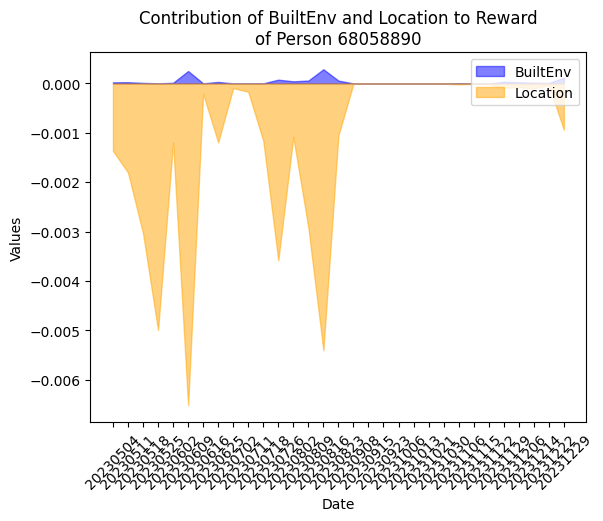

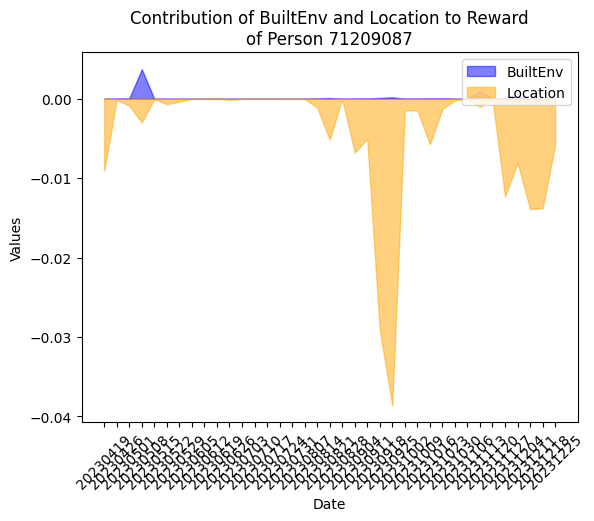

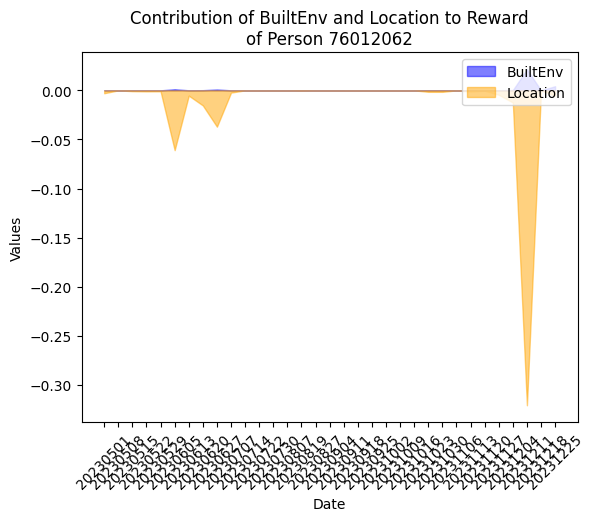

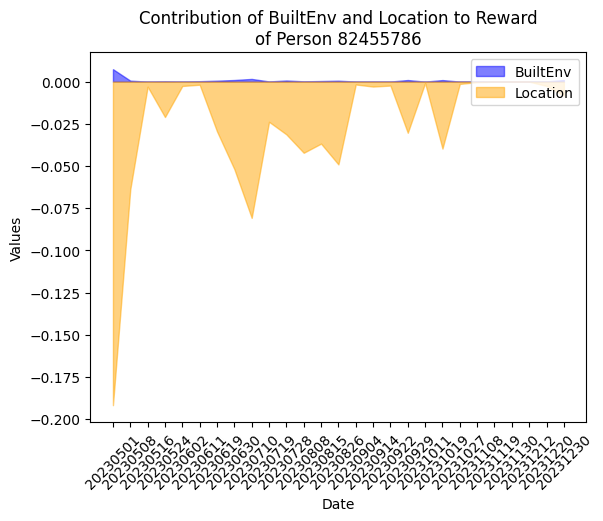

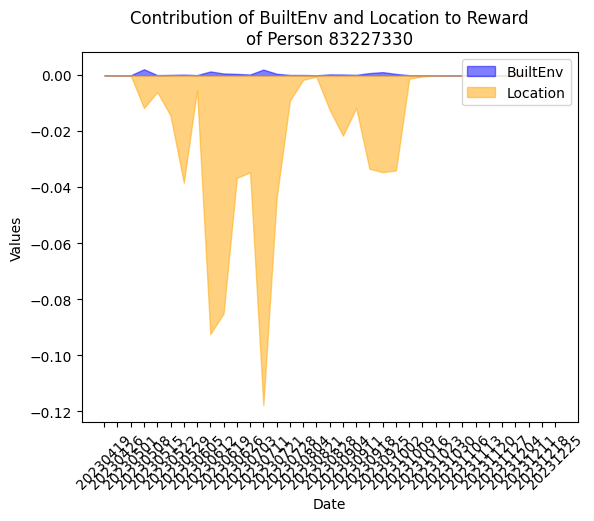

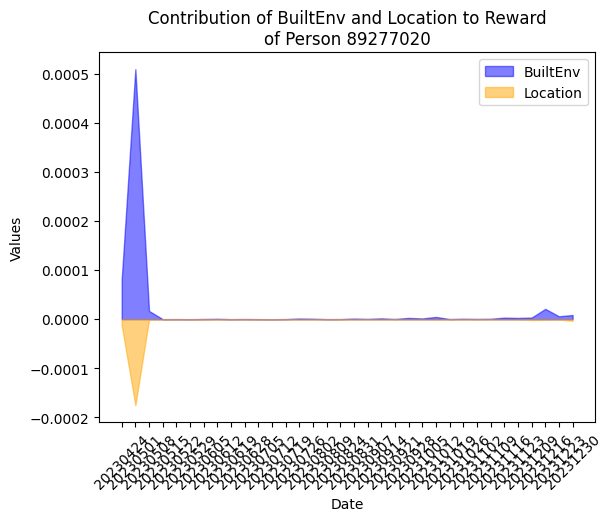

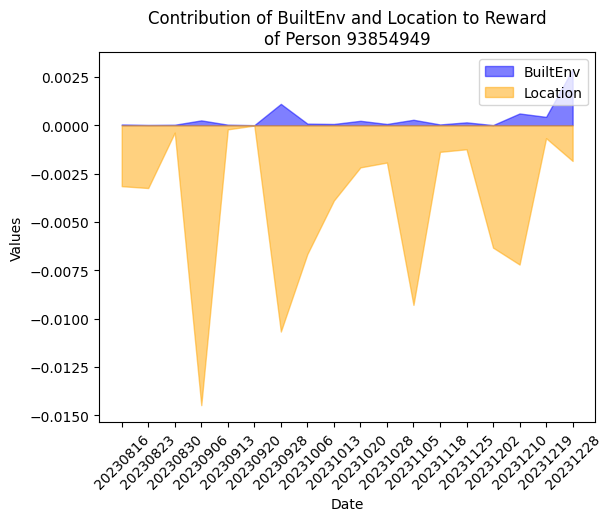

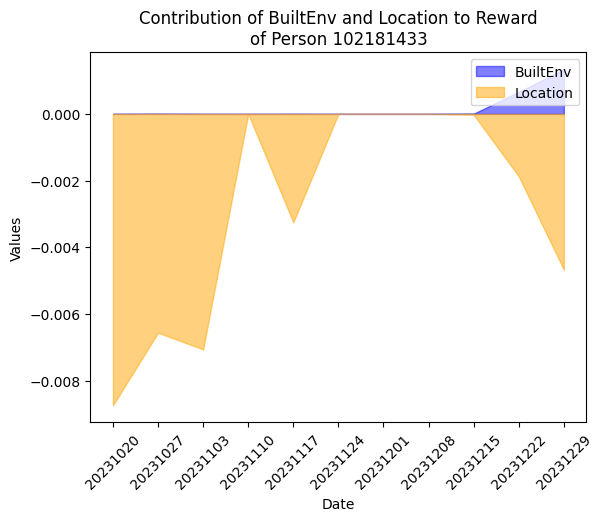

In [18]:
from matplotlib import pyplot as plt
for who in who_list:
    drawShap(who)

In [188]:
# repeat the two 1d array to form a 2-column matrix
r = reward_res[(1102234, 20230501)] 
r = np.repeat(r, 2).reshape(-1, 2)

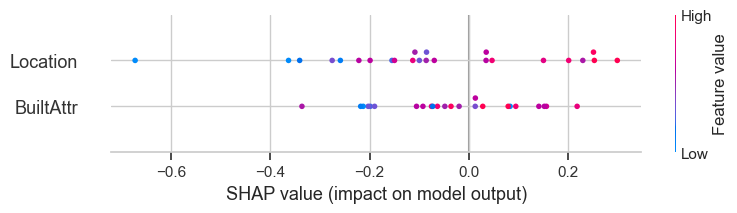

In [189]:
shap_final = shap_val[20230501]
shap.summary_plot(shap_final.values, features=r, feature_names=shap_final.columns, plot_type="dot")



In [85]:
ans = [np.abs(shap.to_numpy()).mean(axis=0) for d, shap in shap_val.items()]
shap_data_array = np.array(ans)

In [86]:
r_baseline = np.array([abs(rarray).mean() for rarray in reward_res.values()])

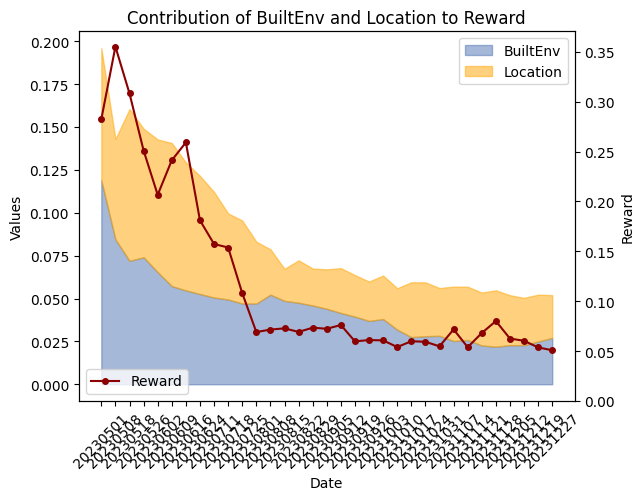

In [103]:
plt.style.use('default')
x = np.arange(len(shap_val))
# 创建图形和轴
fig, ax = plt.subplots()

y1 = shap_data_array[:, 0]
y2 = shap_data_array[:, 1]
# 绘制堆叠区域
ax.fill_between(x, y1, color='b', alpha=0.5, label='BuiltEnv')  # 蓝色区域
ax.fill_between(x, y1, y2, color='orange', alpha=0.5, label='Location')  # 绿色区域，堆叠在蓝色区域之上

# 设置图例
ax.legend(loc='upper right')

# 设置图表标题和坐标轴标签
ax.set_title('Contribution of BuiltEnv and Location to Reward')
ax.set_xlabel('Date')
ax.set_ylabel('Values')

ax_r = ax.twinx()  # 创建第二个坐标轴
ax_r.plot(x, r_baseline, color='darkred', ls='-', marker='o', ms=4, label='Reward')
ax_r.set_ylabel('Reward')
ax_r.legend(loc='lower left')
ax_r.set_ylim(0, None)

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in shap_val.keys()], rotation=45)

# 显示图表
plt.show()

In [105]:
with open('./product/visual/interpretEvo_user1.pkl', 'rb') as f:
    intepret = pickle.load(f)
intepret = intepret[1102234]

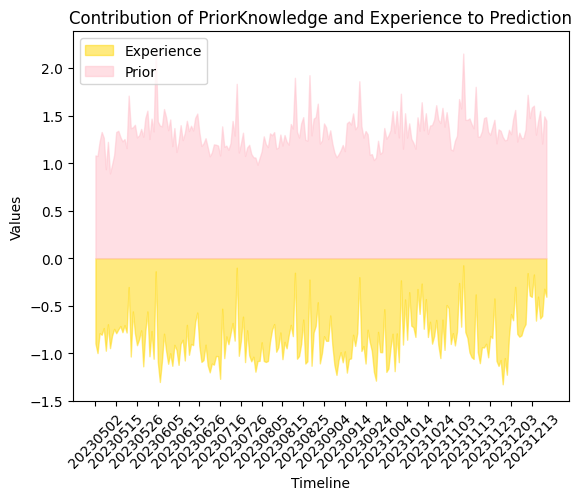

In [47]:
x = intepret.index
# 创建图形和轴
fig, ax = plt.subplots()

y1 = intepret.pr_contrib
y2 = intepret.exp_contrib

# 绘制堆叠区域
ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Experience')  # 绿色区域，堆叠在蓝色区域之上
ax.fill_between(x, y1, color='pink', alpha=0.5, label='Prior')  # 蓝色区域

# 设置图例
ax.legend(loc='upper left')

# 设置图表标题和坐标轴标签
ax.set_title(f'Contribution of PriorKnowledge and Experience to Prediction')
ax.set_xlabel('Timeline')
ax.set_ylabel('Values')

# 将横坐标的标签设置为日期datelist
ax.set_xticks(x[::10])
labels = [str(d) for d in intepret.date]
ax.set_xticklabels(labels[::10], rotation=45)

# 显示图表
plt.show()

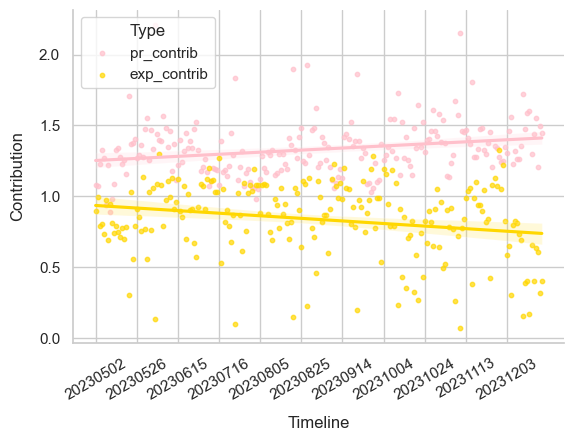

In [185]:
# 绘制散点图
df = intepret.reset_index()
datelist = df.date.tolist()
datelist = [str(d) for d in datelist]
# 导入seaborn
import seaborn as sns
sns.set_theme(style="whitegrid")
# 绘制散点图并且拟合曲线
df = df.melt(id_vars=['index', 'date'])
g = sns.lmplot(data=df, x="index", y="value", hue="variable", legend=True,
               palette=['pink', 'gold'], scatter_kws={"s": 10, "alpha": 0.7},
               facet_kws={"legend_out": False})
# 修改图长宽比为3比2
g.set_axis_labels("Timeline", "Contribution", labelpad=10)
plt.gcf().set_size_inches(6, 4)
# 图例放到下方 平铺
xset = np.arange(0, len(datelist), 20, dtype=int)
plt.gca().set_xticks(xset)
g.set_xticklabels([datelist[i] for i in xset], rotation=30,)
g.legend.set_title("Type")


In [20]:
with open('./product/topoMap/topo_cluster.pkl', 'rb') as f:
    topo = pickle.load(f)

In [21]:
topo

{('093854949',
  20230815): (array([[1.37488789e-03, 1.97065237e-04, 8.79386521e-01, 1.19041526e-01],
         [1.33654843e-03, 1.93819560e-04, 8.80801788e-01, 1.17667844e-01],
         [1.38059547e-03, 1.98264407e-04, 8.79244518e-01, 1.19176622e-01],
         [1.50967155e-03, 2.17481852e-04, 8.73175169e-01, 1.25097678e-01]]), {4: (114.38827514648438,
    22.7471923828125),
   6: (114.38346862792967, 22.74238586425781),
   9: (114.38758850097656, 22.746505737304688),
   24: (114.39445495605467,
    22.74238586425781)}, array([[1.39605308e-03],
         [2.00565744e-04],
         [8.78517399e-01],
         [1.19885982e-01]]), array([0, 2, 0, 1], dtype=int64)),
 ('093854949',
  20230822): (array([[2.20061710e-02, 7.78565311e-06, 3.06550400e-06, 9.68913368e-01,
          8.94499695e-03, 1.24612406e-04],
         [1.06762887e-01, 3.37261080e-06, 1.87000409e-06, 5.24761689e-01,
          3.68435453e-01, 3.47274902e-05],
         [1.07507575e-01, 3.32832503e-06, 1.83870676e-06, 5.20886747e-0

In [206]:
import geopandas as gpd
import networkx as nx
from topoMap import computeTransLimit

In [218]:
shenzhen_grid = gpd.read_file('./data/ss_city_grid/ss_city_grid_by_cover.shp')

In [222]:
def draw_topo_map(topo, date):
    # move to module
    one_topo = topo[date]
    transitionProbsEdit, id_coorders_mapping_edit, stationary, cluster_labels = one_topo
    keylist = list(id_coorders_mapping_edit.keys())
    # average the coordinates of the points in each cluster
    labpos = [np.where(cluster_labels == lab)[0] for lab in np.unique(cluster_labels)]
    transitionClust = np.empty((len(labpos), len(labpos)))
    for i in range(len(labpos)):
        source = transitionProbsEdit[labpos[i], :].mean(axis=0)
        for j in range(len(labpos)):
            transitionClust[i, j] = source.take(labpos[j]).sum()

    transitionClust /= transitionClust.sum(axis=1)[:, None]
    weight = computeTransLimit(transitionClust).real
    transitionCorrected = transitionClust * weight
    
    # ref 矩阵中的累积最小值
    # search the position where sits the smallest values whose cumulated sum is larger than 0.05
    threshold = 0.5
    transitionCorrectedFlatten = transitionCorrected.flatten()
    sorted = np.sort(transitionCorrectedFlatten)
    cut_pos = len(np.where(np.cumsum(sorted) <= threshold)[0])
    smalllest_idx = np.argsort(transitionCorrectedFlatten)[:cut_pos]
    # transitionCorrectedFlatten[smalllest_idx] = np.nan
    smalllest_idx_2d = np.unravel_index(smalllest_idx, transitionCorrected.shape)

    weighgFlatten = weight.flatten()
    sorted = np.sort(weighgFlatten)
    cut_pos = len(np.where(np.cumsum(sorted) <= threshold)[0])
    smalllest_idx_weight = np.argsort(weighgFlatten)[:cut_pos]
    
    transAdj = transitionCorrected.copy()
    transAdj[smalllest_idx_2d] = 0
    
    # get the average position of the points in each cluster
    cluster_coords_array = []
    for onelab2pos in labpos:
        cluster_coords_list = [id_coorders_mapping_edit[keylist[onepos]] for onepos in onelab2pos]
        cluster_coords = np.array(cluster_coords_list).mean(axis=0)
        cluster_coords = tuple(cluster_coords.tolist())
        cluster_coords_array.append(cluster_coords)
        
    def drawNetworkOnMap(shenzhen_grid,  alpha=0.2):
        print("Function starts.")

        # Create a graph from the CSV data
        G = nx.DiGraph()
        for i, coord in enumerate(cluster_coords_array):
            if not np.isin(i, smalllest_idx_weight):
                G.add_node(str(coord), pos=coord, weight=weight[i, 0])

        # count = 10
        size = len(cluster_coords_array)
        for i in range(size):
            if np.isin(i, smalllest_idx_weight):
                continue
            for j in range(size):
                if i != j and not np.isin(j, smalllest_idx_weight):
                    weight_value = transAdj[i, j]
                    if weight_value > 0:
                        G.add_edge(str(cluster_coords_array[i]), str(cluster_coords_array[j]), weight=weight_value)
        # Extract and scale weights for the edges
        weights = [G[u][v]['weight'] for u, v in G.edges()]
        print("weights: ", weights)
        alphaw = np.interp(weights, (min(weights), max(weights)), (0, 1))
        # Extract the size weighs for the nodes
        node_size = [G.nodes[n]['weight'] for n in G.nodes()]
        print("node_size: ", node_size)
        node_size = np.log(np.array(node_size))
        node_size = np.interp(node_size, (min(node_size), max(node_size)), (10, 100))
        # Position
        pos = nx.get_node_attributes(G, 'pos')
        # Plot the network on the map
        f, ax = plt.subplots(1, 1, figsize=(10, 10))
        shenzhen_grid.plot(ax=ax, linewidth=1, alpha=alpha, color='gray')
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size)
        nx.draw_networkx_edges(G, pos, width=3, alpha = alphaw, edge_color=weights, 
                            edge_vmax=max(weights),
                            edge_cmap=plt.cm.Reds, arrows=True, arrowstyle='-|>', ax=ax)
        ax.set_title('Topological Cognitive Map on Date {date}')
        return f

    return drawNetworkOnMap(shenzhen_grid)
        


In [ ]:
date = list(topo.keys())
res = [draw_topo_map(topo, d) for d in date]

In [ ]:
from matplotlib.animation import ArtistAnimation, PillowWriter  # PillowWriter用于保存为GIF
# 创建一个新的figure和axes（这些将用作动画的基础）
fig, ax = plt.subplots()

# 将每个figure中的所有artists（例如，线条，文本等）收集到一个列表中
artists = []
for f in res:
    for artist in f.axes[0].get_children():
        # 必须克隆原始artists到新的axes中，因为一个artist不能同时属于两个不同的axes
        artists.append([artist])
# 创建动画
anim = ArtistAnimation(fig, artists, interval=200, blit=True)

# 保存动画
anim.save('animation.gif', writer=PillowWriter(fps=5))

In [58]:
with open('./product/iterationEvo.pkl', 'rb') as f:
    intepret_res = pickle.load(f)


In [77]:
def drawExplainRecent(who):
    who_idx = who_list.index(who)
    intepret = intepret_res[who_idx]
    
    x = intepret.index
    # 创建图形和轴
    fig, ax = plt.subplots()

    y1 = intepret.re_contrib
    y2 = intepret.exp_contrib

    # 绘制堆叠区域
    ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Recent Experience')  # 绿色区域，堆叠在蓝色区域之上
    ax.fill_between(x, y1, color='pink', alpha=0.5, label='Recent Knowledge')  # 蓝色区域

    # 设置图例
    ax.legend(loc='upper left')

    # 设置图表标题和坐标轴标签
    ax.set_title(f'Contribution of Recent Knowledge and Experience to Prediction\nof Person {who}')
    ax.set_xlabel('Timeline')
    ax.set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax.set_xticks(x[::10])
    labels = [str(d) for d in intepret.date]
    ax.set_xticklabels(labels[::10], rotation=45)

    # 显示图表
    plt.savefig(save_path + 'person_interp/Explain_Recent_{who:09d}.png'.format(who=who))    
    plt.show()
    
def drawExplainPrior(who):
    who_idx = who_list.index(who)
    intepret = intepret_res[who_idx]
    
    x = intepret.index
    # 创建图形和轴
    fig, ax = plt.subplots()

    y1 = intepret.pr_contrib
    y2 = intepret.acu_contrib

    # 绘制堆叠区域
    ax.fill_between(x, -y2, color='gold', alpha=0.5, label='Accumulated Experience')  # 绿色区域，堆叠在蓝色区域之上
    ax.fill_between(x, y1, color='pink', alpha=0.5, label='Prior Knowledge')  # 蓝色区域

    # 设置图例
    ax.legend(loc='upper left')

    # 设置图表标题和坐标轴标签
    ax.set_title(f'Contribution of Prior Knowledge and Experience to Prediction\nof Person {who}')
    ax.set_xlabel('Timeline')
    ax.set_ylabel('Values')

    # 将横坐标的标签设置为日期datelist
    ax.set_xticks(x[::10])
    labels = [str(d) for d in intepret.date]
    ax.set_xticklabels(labels[::10], rotation=45)

    # 显示图表
    plt.savefig(save_path + 'person_interp/Explain_Prior_{who:09d}.png'.format(who=who))    
    plt.show()

In [ ]:
for who in who_list:
    drawExplainPrior(who)